In [1]:
!pip install progressbar

In [35]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
import warnings

from etl.etl import Data_Correction, AttributeMapping, ratio_missing, impute_na, categorize, etl_transform, etl_save_data

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, plot_confusion_matrix, roc_auc_score


import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30000)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

In [4]:
target = mailout_train[['LNR', 'RESPONSE']]
target.set_index('LNR', inplace=True)
target = target.astype(float)

In [5]:
with open('ref_features.pkl', 'rb') as f:
    ref_features = pickle.load(f)
    
with open('attr_mapping.pkl', 'rb') as f:
    attr_mapping = pickle.load(f)

### Data Cleaning

In [6]:
mailout_train_cleaned,_ = etl_transform(mailout_train, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


### Training-Testing Data Preperation

Applying a test-train split on the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train_cleaned, target, stratify=target, test_size=0.2)

Removing the bias in the training data. However this does come with a significant cost of loosing data with label 0

In [8]:
y_train_0 = y_train[y_train['RESPONSE']==0].sample(y_train[y_train['RESPONSE']==1].shape[0]*1)
y_train_1 = y_train[y_train['RESPONSE']==1]
y_train_modified = pd.concat([y_train_0, y_train_1])
X_train_modified = X_train.loc[y_train_modified.index]

Investigating the training and test data sets

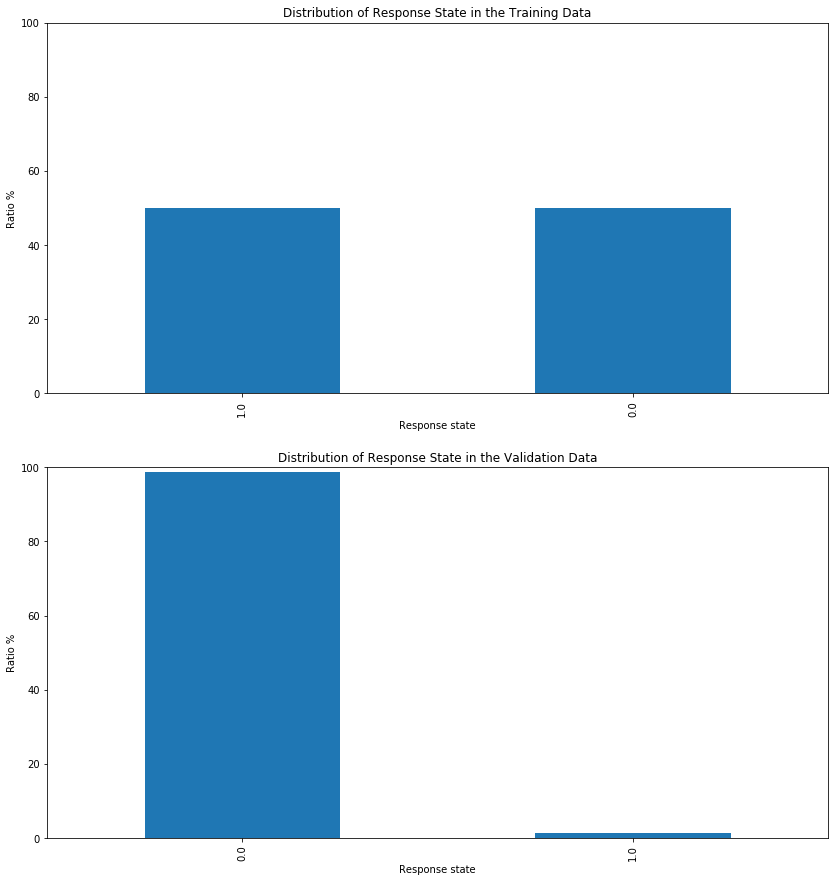

In [9]:
plt.figure(figsize=(14,15))
plt.subplot(2,1,1)
(y_train_modified['RESPONSE'].value_counts()/y_train_modified['RESPONSE'].shape[0]*100).plot(kind='bar')
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Training Data')

plt.subplot(2,1,2)
(y_test['RESPONSE'].value_counts()/y_test['RESPONSE'].shape[0]*100).plot(kind='bar')
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Validation Data')
plt.show()

The training set labels are distributed evenly as intended however, there is a huge bias that can be seen in the test data.

### Model Selection

Creating the Supervised Learning pipelines. 4 models will be tested, these are KNN, RandomForestClassifier, GradientBoostingClassifier and GaussianNB (naive bayes).

In [10]:
models = dict([])
estimators = {'KNN_clf': KNeighborsClassifier(),
              'RF_clf': RandomForestClassifier(),
              'GB_clf': GradientBoostingClassifier(),
              'NB_clf': GaussianNB()}

# Creating dictionary of pipelines
pipelines = dict([])
for key, val in estimators.items():
    pipelines[key] = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(200)),
                               ('clf', val)
                              ])

Generating the evaluation function as ROC-AUC

ROC AUC is used as the evaluation metric for the model. This is because this metric works with the final prediction label. Another advantage is that it is more sensitive in biased data which is our case with our test set.

In [11]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

To keep the models comparable to one another, the number of neighbours for KNN and n estimators parameters for RandomForest and GradientBoostingClassifier will be tuned with grid search.

In [12]:
parameters_KNN = {
        'clf__n_neighbors': [3, 5, 8, 10, 15]
        }

parameters_ensemble =  {
        'clf__n_estimators': [500, 750, 1000, 1250, 1500]
        }

model_KNN = GridSearchCV(pipelines['KNN_clf'], param_grid=parameters_KNN, n_jobs=-1, verbose=10, cv=5, return_train_score=True, scoring=roc_auc_scorer)
model_RF = GridSearchCV(pipelines['RF_clf'], param_grid=parameters_ensemble, n_jobs=-1, verbose=10, cv=5, return_train_score=True, scoring=roc_auc_scorer)
model_GB = GridSearchCV(pipelines['GB_clf'], param_grid=parameters_ensemble, n_jobs=-1, verbose=10, cv=5, return_train_score=True, scoring=roc_auc_scorer)
model_NB = pipelines['NB_clf']

Calculating the best obtained scores for the model using grid search and corss validation score for GaussianNB.

In [13]:
KNN_score = model_KNN.fit(X_train_modified, y_train_modified).best_score_
RF_score = model_RF.fit(X_train_modified, y_train_modified).best_score_
GB_score = model_GB.fit(X_train_modified, y_train_modified).best_score_
NB_score = cross_val_score(model_NB, X_train_modified, y_train_modified, cv=5, scoring=roc_auc_scorer).mean()
#as a additinal step model_NB also needs to be fitted to the data
model_NB.fit(X_train_modified, y_train_modified)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    3.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    3.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    3.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    3.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.9s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   12.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   17.0s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   21.6s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   24.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   28.9s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.1min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  1.4min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.9min remaining:   35.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  2.0min remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

As a additional step the test set is used to validate the model performance with ROC AUC score.

In [14]:
KNN_score_test = roc_auc_scorer(model_KNN, X_test, y_test)
RF_score_test = roc_auc_scorer(model_RF, X_test, y_test)
GB_score_test = roc_auc_scorer(model_GB, X_test, y_test)
NB_score_test = roc_auc_scorer(model_NB, X_test, y_test)

Evaluating the findings

In [15]:
print('-KNN- \nTraining Score: %.2f\nTest Score: %.2f\n' % (KNN_score, KNN_score_test), '-x-' *5)
print('-RF- \nTraining Score: %.2f\nTest Score: %.2f\n' % (RF_score, RF_score_test), '-x-' *5)
print('-GB- \nTraining Score: %.2f\nTest Score: %.2f\n' % (GB_score, GB_score_test), '-x-' *5)
print('-NB- \nTraining Score: %.2f\nTest Score: %.2f\n' % (NB_score, NB_score_test), '-x-' *5)

-KNN- 
Training Score: 0.54
Test Score: 0.53
 -x--x--x--x--x-
-RF- 
Training Score: 0.54
Test Score: 0.53
 -x--x--x--x--x-
-GB- 
Training Score: 0.53
Test Score: 0.51
 -x--x--x--x--x-
-NB- 
Training Score: 0.52
Test Score: 0.51
 -x--x--x--x--x-


The above results show that KNN and RF gives a higher ROC AUC score then the other models in the test and training sets. Therefore for further optimization KNN is selected because it is faster to train.

### Hyper Parameter Tuning

In [16]:
pipelines['KNN_clf'].get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('clf',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                        weights='uniform'))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pc

In [17]:
parameters_selected_model = {
    'pca__n_components': [100, 150, 200],
    'clf__leaf_size': list(range(20, 101, 10)),
    'clf__n_neighbors': list(range(2, 30, 3)),
    'clf__p': [1, 2, 3]
    }

In [18]:
selected_model = GridSearchCV(pipelines['KNN_clf'], param_grid=parameters_selected_model, n_jobs=-1, verbose=10, cv=5, return_train_score=True, scoring=roc_auc_scorer)
selected_model.fit(X_train_modified, y_train_modified)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=200, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                        

Checking what was found from gridseach

In [19]:
print(selected_model.best_params_)

{'clf__leaf_size': 20, 'clf__n_neighbors': 5, 'clf__p': 1, 'pca__n_components': 150}


### Testing the Model

In [20]:
print('Training Score: %.2f\nTest Score: %.2f' %(selected_model.best_score_, roc_auc_scorer(selected_model, X_test, y_test)))

Training Score: 0.55
Test Score: 0.51


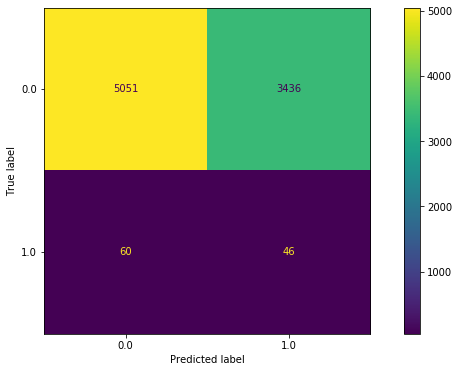

In [36]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
plot_confusion_matrix(selected_model, X_test, y_test, values_format='d', ax=ax)
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [22]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

In [23]:
mailout_test_cleaned,_ = etl_transform(mailout_test, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


In [24]:
y_pred = selected_model.predict(mailout_test_cleaned)

In [25]:
mailout_test_predicted = pd.DataFrame({'LNR':mailout_test_cleaned.index, 'RESPONSE':y_pred})

In [26]:
mailout_test_predicted.to_csv('mailout_test_predicted.csv', index=False)

Submission to Kaggle got a score of 0.49118